In [4]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc, precision_score, recall_score
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler

SEED = 1996
FOLDS = 10
TARGET = "y"
VERSION = "lgbm-strech_train"

In [5]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sub = pd.read_csv("../data/submission_sample.csv")
df_meta = pd.read_csv("../data/metadata.csv")

In [6]:
full = pd.concat([df_train, df_test], sort = False)

# [value, count, var nubmer, target]

In [7]:
from tqdm import tqdm

dfs_list = []
for i in tqdm(range(68)):
    name = 'count_' + str(i+1)
    var = 'var' + str(i+1)
    if full[var].dtype == 'float':
#         temp = full[var].to_frame(var)
        full[var] = full[var].round(2)
        full[name] = full.groupby(var)[var].transform('count')
    else:
        full[name] = full.groupby(var)[var].transform('count')
    
    df_temp = full[full['y'].notna()][[var, name, 'y']]
    df_temp['var_number'] = i+1
    df_temp.columns = ['value', 'count', 'y', 'var_number']
    df_temp = df_temp[['value', 'count', 'var_number', 'y']]
                      
    dfs_list.append(df_temp)
    
df_new_train = pd.concat(dfs_list, axis=0)
df_new_train.head()

100%|██████████| 68/68 [00:01<00:00, 34.88it/s]


,value,count,var_number,y
0,18.0,6406,1,1.0
1,4.0,12935,1,0.0
2,0.0,403,1,0.0
3,20.0,654,1,0.0
4,7.0,2455,1,1.0


In [8]:
df_new_train['var_number'] = df_new_train['var_number'].astype('category')

In [9]:
df_new_train = df_new_train.reset_index()

In [10]:
df_new_train.tail()

,index,value,count,var_number,y
960359,14118,0.15,2329,68,0.0
960360,14119,0.20,1598,68,0.0
960361,14120,0.16,1626,68,0.0
960362,14121,0.13,1668,68,0.0
960363,14122,0.13,1668,68,0.0


In [34]:
import lightgbm as lgb

features_to_drop = [TARGET, 'old_index']
features = [ft for ft in df_new_train.columns if ft not in features_to_drop]

importances = df_new_train[features].columns.to_frame()
train_preds = df_new_train[TARGET].to_frame()
train_preds["preds"] = 0

kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_index, valid_index) in enumerate(kfold.split(df_new_train, df_new_train[TARGET])):
    x_train, x_valid = df_new_train.loc[train_index][features], df_new_train.loc[valid_index][features]
    y_train, y_valid = df_new_train.loc[train_index][TARGET], df_new_train.loc[valid_index][TARGET]
    
    clf = lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=5000,
        random_state=SEED,
        boosting="gbdt",
        objective="binary",
        n_jobs=-1
    )
    
    clf.fit(
        x_train,
        y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric="auc",
        early_stopping_rounds=500,
        verbose=500
    )
    
    y_pred = clf.predict_proba(x_valid, num_iteration=clf.best_iteration_)[:, 1]
#     pd.Series(y_pred).rank()/len(y_pred)
    train_preds.loc[valid_index, "preds"] = y_pred
    
    print(f"Fold {fold+1}, AUC: {roc_auc_score(y_valid, y_pred)}")
    gc.collect()
    
print(f"CV AUC: {roc_auc_score(train_preds[TARGET], train_preds['preds'])}")

Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.65674	valid_0's binary_logloss: 0.478031
[1000]	valid_0's auc: 0.66053	valid_0's binary_logloss: 0.476024
[1500]	valid_0's auc: 0.661541	valid_0's binary_logloss: 0.475297
[2000]	valid_0's auc: 0.661654	valid_0's binary_logloss: 0.475091
Early stopping, best iteration is:
[1745]	valid_0's auc: 0.661752	valid_0's binary_logloss: 0.475128
Fold 1, AUC: 0.6617521770445871
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.657498	valid_0's binary_logloss: 0.477712
[1000]	valid_0's auc: 0.661672	valid_0's binary_logloss: 0.475655
[1500]	valid_0's auc: 0.662767	valid_0's binary_logloss: 0.474934
[2000]	valid_0's auc: 0.662712	valid_0's binary_logloss: 0.474725
Early stopping, best iteration is:
[1618]	valid_0's auc: 0.662818	valid_0's binary_logloss: 0.474856
Fold 2, AUC: 0.6628175701599097
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.6

In [35]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [36]:
gc.collect()

0

In [37]:
df_new_train['preds'] = train_preds['preds']
df_new_train.head()

,index,value,count,var_number,y,preds
0,0,18.0,6406,1,1.0,0.983540
1,1,4.0,12935,1,0.0,0.376926
2,2,0.0,403,1,0.0,0.271408
3,3,20.0,654,1,0.0,0.229654
4,4,7.0,2455,1,1.0,0.369009


In [46]:
original = df_new_train.groupby("index").apply(lambda x: x['preds'].prod())
original.head()

index
0    4.719331e-01
1    2.426743e-37
2    8.811897e-34
3    2.559833e-34
4    2.890700e-33
dtype: float64

In [69]:
y_preds = np.zeros(df_train.shape[0])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_index, valid_index) in enumerate(kfold.split(df_train, df_train[TARGET])):
    
    y_valid = df_new_train.loc[valid_index][TARGET]
    y_pred = original.loc[valid_index]
    y_preds[valid_index] = pd.Series(y_pred).rank()/len(y_pred)
    
    print(f"Fold {fold+1}, AUC: {roc_auc_score(y_valid, y_pred)}")
    gc.collect()
    
print(f"CV AUC: {roc_auc_score(df_train[TARGET], y_preds)}")

Fold 1, AUC: 0.7047605710506866
Fold 2, AUC: 0.717175866495507
Fold 3, AUC: 0.7021231571167386
Fold 4, AUC: 0.683738850231168
Fold 5, AUC: 0.7001844673796292
CV AUC: 0.7015983229607772


100%|██████████| 1000/1000 [00:24<00:00, 41.20it/s]


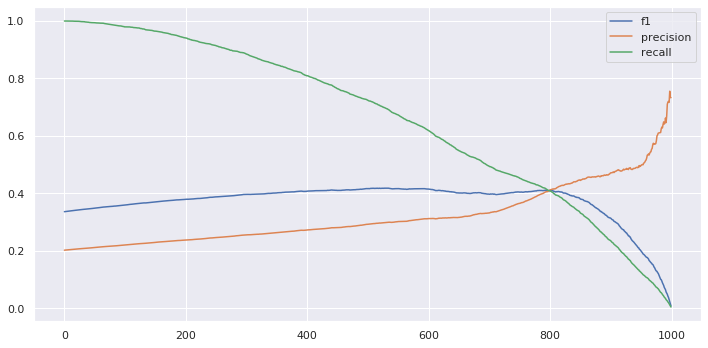

max_f1 [0.532]: 0.41804924442565783


In [70]:
f1, precision, recall = [], [], []
max_f1_threshold = -1
max_f1 = -1
for i in tqdm(range(1000)):
    _i = i / 1000.0
    
    y_pred = np.where(y_preds > _i, 1, 0)
    
    _precision = precision_score(df_train[TARGET], y_pred)
    if _precision == 1.0:
        break
    _f1 = f1_score(df_train[TARGET], y_pred)
    if _f1 > max_f1:
        max_f1 = _f1
        max_f1_threshold = _i
    
    f1.append(_f1)
    precision.append(_precision)
    recall.append(recall_score(df_train[TARGET], y_pred))
    
plt.figure(figsize=[10, 5])
plt.plot(range(len(f1)), f1, label="f1")
plt.plot(range(len(f1)), precision, label="precision")
plt.plot(range(len(f1)), recall, label="recall")
plt.legend()
plt.tight_layout()
plt.show()

print(f"max_f1 [{max_f1_threshold}]: {max_f1}")
# max_f1 [0.776]: 0.6822942643391521

In [73]:
def opt_f1(y_true, y_hat):
    f1, precision, recall = [], [], []
    max_f1_threshold = -1
    max_f1 = -1
    for i in range(100):
        _i = i / 100.0

        y_pred = np.where(y_hat > _i, 1, 0)

        _precision = precision_score(y_true, y_pred)
        if _precision == 1.0:
            break
        _f1 = f1_score(y_true, y_pred)
        if _f1 > max_f1:
            max_f1 = _f1
            max_f1_threshold = _i

        f1.append(_f1)
        precision.append(_precision)
        recall.append(recall_score(y_true, y_pred))
        
    return np.where(y_hat > max_f1_threshold, 1, 0)

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
original = df_new_train.groupby("index").apply(lambda x: opt_f1(x[TARGET], x['preds']))
original.head()

100%|██████████| 100/100 [00:00<00:00, 222.67it/s]


100%|██████████| 100/100 [00:00<00:00, 218.77it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 215.96it/s]


100%|██████████| 100/100 [00:00<00:00, 219.76it/s]


100%|██████████| 100/100 [00:00<00:00, 204.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 57%|█████▋    | 57/100 [00:00<00:00, 145.33it/s]


KeyboardInterrupt: 

In [ ]:
y_preds = np.zeros(df_train.shape[0])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_index, valid_index) in enumerate(kfold.split(df_train, df_train[TARGET])):
    
    y_valid = df_new_train.loc[valid_index][TARGET]
    y_pred = original.loc[valid_index]
    y_preds[valid_index] = pd.Series(y_pred).rank()/len(y_pred)
    
    print(f"Fold {fold+1}, AUC: {roc_auc_score(y_valid, y_pred)}")
    gc.collect()
    
print(f"CV AUC: {roc_auc_score(df_train[TARGET], y_preds)}")